# Result Analysis

In this notebook, we will analyze the evaluation results of multiple image classification models. We will compare their overall performance, examine confusion matrices, and investigate common misclassifications, especially for challenging or similar classes. This analysis will help us understand the strengths and weaknesses of each model and guide future improvements.

In [4]:
# Import necessary libraries
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
import os
import numpy as np


In the next few cells, we will perform the main analysis of the evaluation results for each image classification model. This includes:

- Loading metrics and predictions for each model defined in `MODEL_CONFIGS`
- Printing overall performance metrics (macro and weighted F1-scores)
- Identifying the top and worst performing classes based on F1-score
- Plotting and saving confusion matrices for each model
- Analyzing common misclassifications for the lowest performing classes
- Summarizing and comparing the overall performance of all models in a single table

This analysis helps us understand model strengths, weaknesses, and areas for improvement.

In [19]:

# --- Configuration ---
MODEL_CONFIGS = [
    {
        "name": "MobileNetV2 (Head Trained, Augmentation)",
        "prefix": "mobilenet_head_aug",
        "metrics_file": "../results/evaluation/eval_metrics_mobilenet_head_aug.csv",
        "predictions_file": "../results/evaluation/predictions_mobilenet_head_aug.csv"
    },
    {
        "name": "MobileNetV2 (Mid Trained, No Augmentation)",
        "prefix": "mobilenet_mid_noaug",
        "metrics_file": "../results/evaluation/eval_metrics_mobilenet_mid_noaug.csv",
        "predictions_file": "../results/evaluation/predictions_mobilenet_mid_noaug.csv"
    },
    {
        "name": "MobileNetV2 (Head Trained, No Augmentation)",
        "prefix": "mobilenet_head_noaug",
        "metrics_file": "../results/evaluation/eval_metrics_mobilenet_head_noaug.csv",
        "predictions_file": "../results/evaluation/predictions_mobilenet_head_noaug.csv"
    },
    {
        "name": "MobileNetV2 (Mid Trained, Augmentation)",
        "prefix": "mobilenet_mid_aug",
        "metrics_file": "../results/evaluation/eval_metrics_mobilenet_mid_aug.csv",
        "predictions_file": "../results/evaluation/predictions_mobilenet_mid_aug.csv"
    },
    {
        "name": "ResNet50 (Mid Trained, No Augmentation)",
        "prefix": "resnet_mid_noaug",
        "metrics_file": "../results/evaluation/eval_metrics_resnet_mid_noaug.csv",
        "predictions_file": "../results/evaluation/predictions_resnet_mid_noaug.csv"
    },
    {
        "name": "ResNet50 (Head Trained, Augmentation)",
        "prefix": "resnet_head_aug",
        "metrics_file": "../results/evaluation/eval_metrics_resnet_head_aug.csv",
        "predictions_file": "../results/evaluation/predictions_resnet_head_aug.csv"
    },
    {
        "name": "ResNet50 (Head Trained, No Augmentation)",
        "prefix": "resnet_head_noaug",
        "metrics_file": "../results/evaluation/eval_metrics_resnet_head_noaug.csv",
        "predictions_file": "../results/evaluation/predictions_resnet_head_noaug.csv"
    },
    {
        "name": "ResNet50 (Mid Trained, Augmentation)",
        "prefix": "resnet_mid_aug",
        "metrics_file": "../results/evaluation/eval_metrics_resnet_mid_aug.csv",
        "predictions_file": "../results/evaluation/predictions_resnet_mid_aug.csv"
    },
]

OUTPUT_DIR = "analysis_outputs"
N_TOP_CLASSES = 5
N_WORST_CLASSES = 5
CM_FIG_SIZE = (18, 15) # Adjusted for ~37 classes


In [20]:

# --- Helper Functions ---
def load_metrics(filepath):
    """Loads evaluation metrics, setting class names as index."""
    try:
        df = pd.read_csv(filepath)
        df = df.rename(columns={df.columns[0]: 'class_name'})
        df.set_index('class_name', inplace=True)
        # Convert metric columns to numeric, coercing errors
        for col in ['precision', 'recall', 'f1-score', 'support']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Warning: Metrics file not found: {filepath}")
        return None

def load_predictions(filepath):
    """Loads prediction details."""
    try:
        return pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Warning: Predictions file not found: {filepath}")
        return None

def get_class_names(metrics_df):
    """Extracts class names, excluding summary rows."""
    if metrics_df is None:
        return []
    class_names = metrics_df.index.tolist()
    return [name for name in class_names if name not in ['macro avg', 'weighted avg']]

def plot_confusion_matrix_custom(y_true_idx, y_pred_idx, display_labels, model_name, prefix):
    """Generates and saves a confusion matrix plot."""
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=np.arange(len(display_labels)))

    plt.figure(figsize=CM_FIG_SIZE)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"confusion_matrix_{prefix}.png"), dpi=300)
    plt.close()
    print(f"Saved confusion matrix for {model_name} to {OUTPUT_DIR}/confusion_matrix_{prefix}.png")

def analyze_specific_confusion(predictions_df, class1_name, class2_name):
    """Analyzes confusion between two specific classes."""
    if predictions_df is None:
        return {}

    confusion_counts = {}
    # Class1 misclassified as Class2
    misclassified_c1_as_c2 = predictions_df[
        (predictions_df['true_label_name'] == class1_name) &
        (predictions_df['predicted_label_name'] == class2_name)
    ].shape[0]
    confusion_counts[f"{class1_name}_as_{class2_name}"] = misclassified_c1_as_c2

    # Class2 misclassified as Class1
    misclassified_c2_as_c1 = predictions_df[
        (predictions_df['true_label_name'] == class2_name) &
        (predictions_df['predicted_label_name'] == class1_name)
    ].shape[0]
    confusion_counts[f"{class2_name}_as_{class1_name}"] = misclassified_c2_as_c1
    return confusion_counts

def get_common_misclassifications(predictions_df, true_class_name, top_n=3):
    """Identifies the most common incorrect predictions for a given true class."""
    if predictions_df is None:
        return pd.Series(dtype='int64')

    misclassifications = predictions_df[
        (predictions_df['true_label_name'] == true_class_name) &
        (predictions_df['true_label_name'] != predictions_df['predicted_label_name'])
    ]
    return misclassifications['predicted_label_name'].value_counts().nlargest(top_n)


In [33]:

# --- Main Analysis ---
if __name__ == "__main__":
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    all_model_summary_metrics = []

    for config in MODEL_CONFIGS:
        print(f"\n{'='*20} Analyzing: {config['name']} {'='*20}")
        metrics_df = load_metrics(config["metrics_file"])
        predictions_df = load_predictions(config["predictions_file"])

        if metrics_df is None:
            print(f"Skipping {config['name']} due to missing metrics file.")
            continue

        class_names_ordered = get_class_names(metrics_df) # Get class names before dropping summary rows

        # Store overall metrics
        summary_metrics = {
            "Model": config["name"],
            "Macro Avg F1-Score": metrics_df.loc['macro avg', 'f1-score'] if 'macro avg' in metrics_df.index else np.nan,
            "Weighted Avg F1-Score": metrics_df.loc['weighted avg', 'f1-score'] if 'weighted avg' in metrics_df.index else np.nan,
            "Macro Avg Precision": metrics_df.loc['macro avg', 'precision'] if 'macro avg' in metrics_df.index else np.nan,
            "Macro Avg Recall": metrics_df.loc['macro avg', 'recall'] if 'macro avg' in metrics_df.index else np.nan,
        }
        all_model_summary_metrics.append(summary_metrics)

        print("\n--- Overall Performance ---")
        print(f"Macro Average F1-Score: {summary_metrics['Macro Avg F1-Score']:.4f}")
        print(f"Weighted Average F1-Score: {summary_metrics['Weighted Avg F1-Score']:.4f}")

        # Filter out summary rows for class-specific analysis
        class_metrics_df = metrics_df.drop(['macro avg', 'weighted avg'], errors='ignore')

        print(f"\n--- Top {N_TOP_CLASSES} Performing Classes (by F1-score) ---")
        top_classes = class_metrics_df['f1-score'].nlargest(N_TOP_CLASSES)
        print(top_classes)

        print(f"\n--- Worst {N_WORST_CLASSES} Performing Classes (by F1-score) ---")
        worst_classes = class_metrics_df['f1-score'].nsmallest(N_WORST_CLASSES)
        print(worst_classes)

    print("\n\n" + "="*20 + " Overall Model Comparison " + "="*20)
    summary_df = pd.DataFrame(all_model_summary_metrics)
    summary_df.set_index("Model", inplace=True)
    print(summary_df.sort_values(by="Macro Avg F1-Score", ascending=False))



==================== Analyzing: MobileNetV2 (Head Trained, Augmentation) ====================

--- Overall Performance ---
Macro Average F1-Score: 74.8200
Weighted Average F1-Score: 74.8900

--- Top 5 Performing Classes (by F1-score) ---
class_name
Keeshond             95.83
Leonberger           91.92
Newfoundland         86.60
Scottish Terrier     86.38
Yorkshire Terrier    86.29
Name: f1-score, dtype: float64

--- Worst 5 Performing Classes (by F1-score) ---
class_name
American Pit Bull Terrier     46.45
Staffordshire Bull Terrier    49.43
Chihuahua                     60.57
Ragdoll                       61.05
Maine Coon                    64.65
Name: f1-score, dtype: float64

==================== Analyzing: MobileNetV2 (Mid Trained, No Augmentation) ====================

--- Overall Performance ---
Macro Average F1-Score: 79.1100
Weighted Average F1-Score: 79.1800

--- Top 5 Performing Classes (by F1-score) ---
class_name
Keeshond              93.53
Pug                   90.43
Germ

## Confusion Matrices
In this section, we visualize and interpret the confusion matrices for each model. Confusion matrices provide a detailed view of how each model performs across all classes, highlighting which classes are most often confused with each other. By examining these matrices, we can identify specific patterns of misclassification, spot challenging class pairs, and better understand the strengths and weaknesses of each model's predictions. The following cells will generate and display confusion matrices for all evaluated models.


==================== Confusion Matrix: MobileNetV2 (Head Trained, Augmentation) ====================


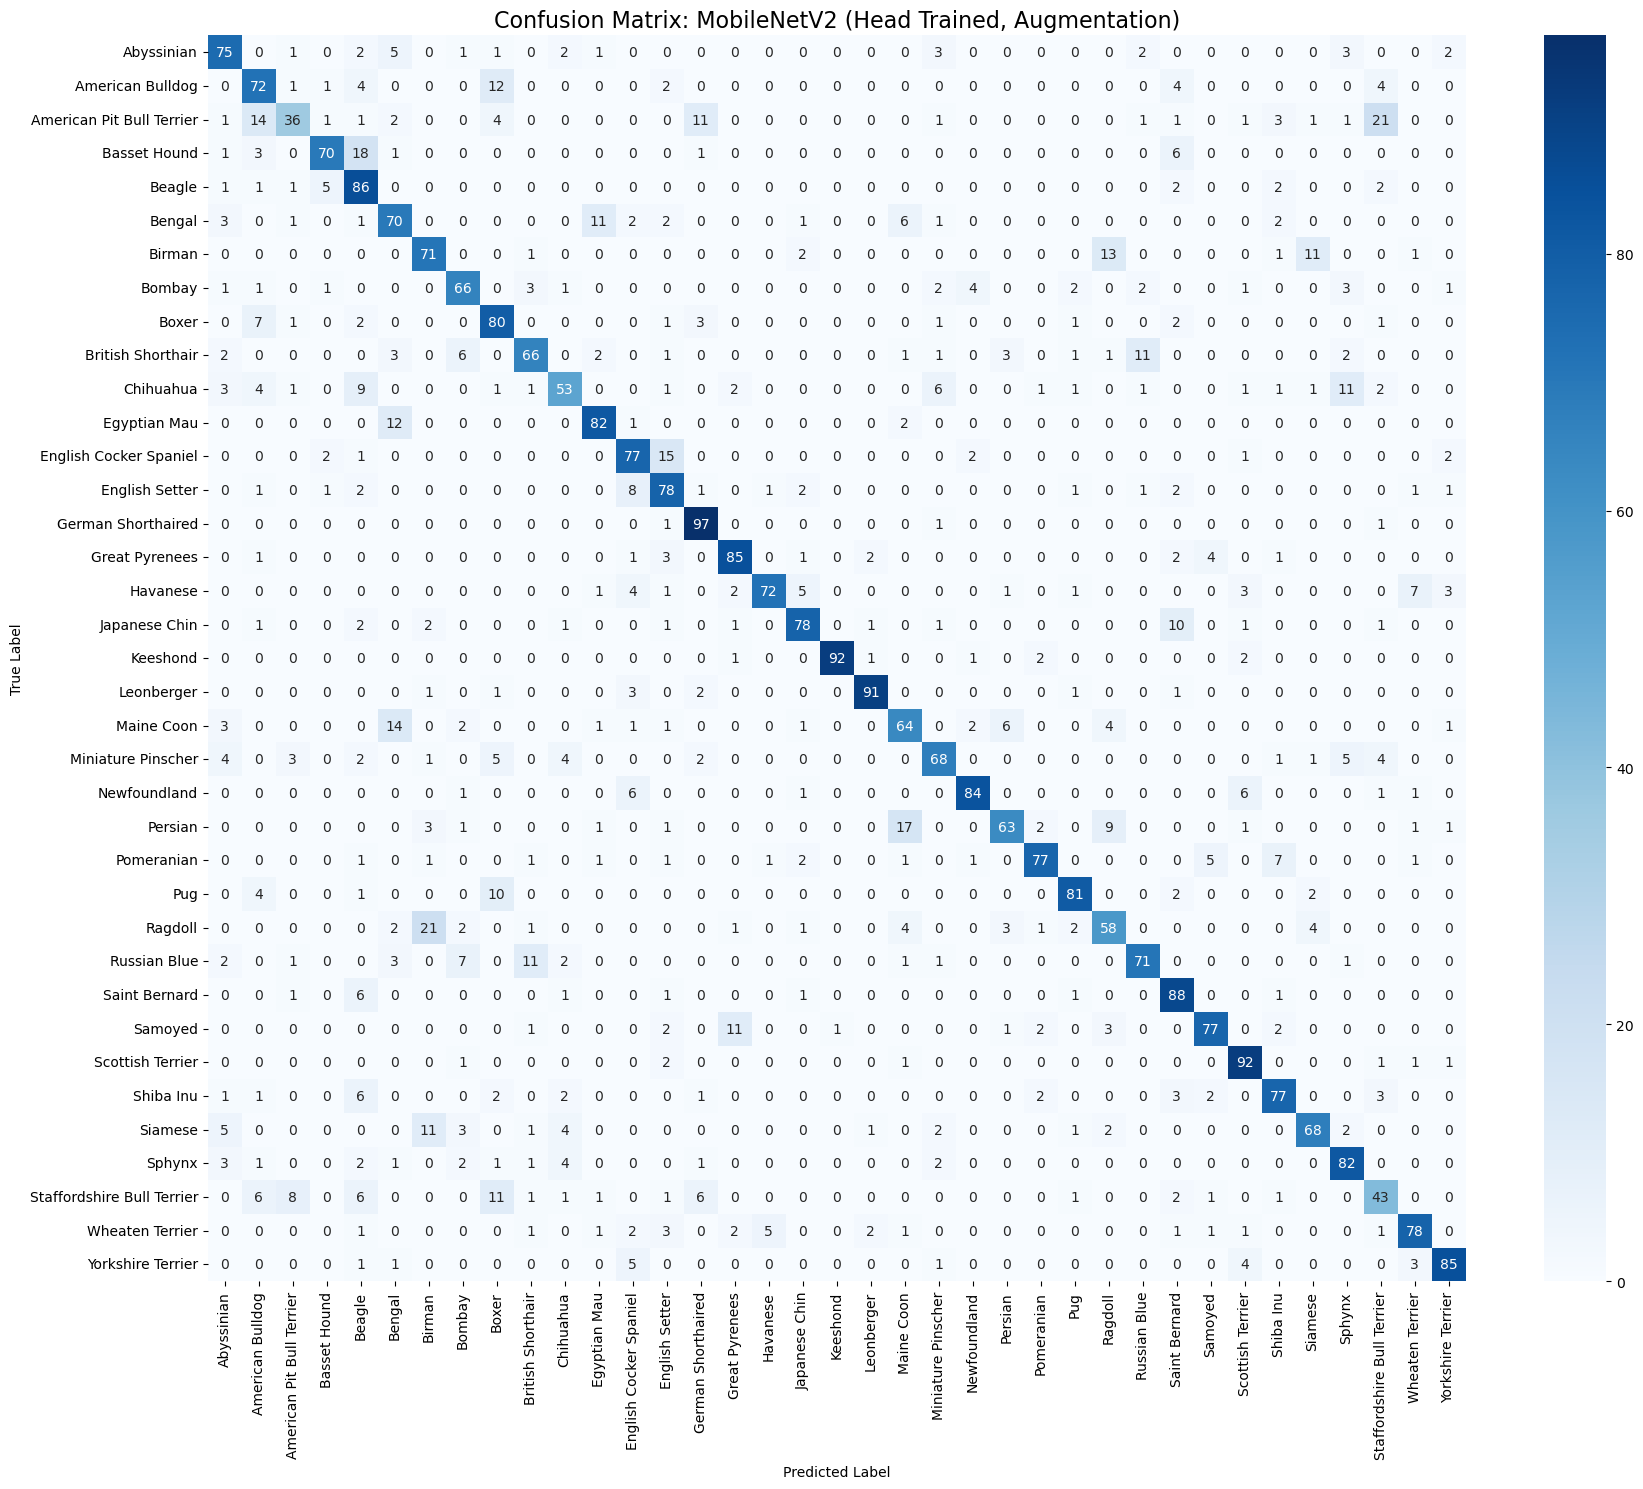


==================== Confusion Matrix: MobileNetV2 (Mid Trained, No Augmentation) ====================


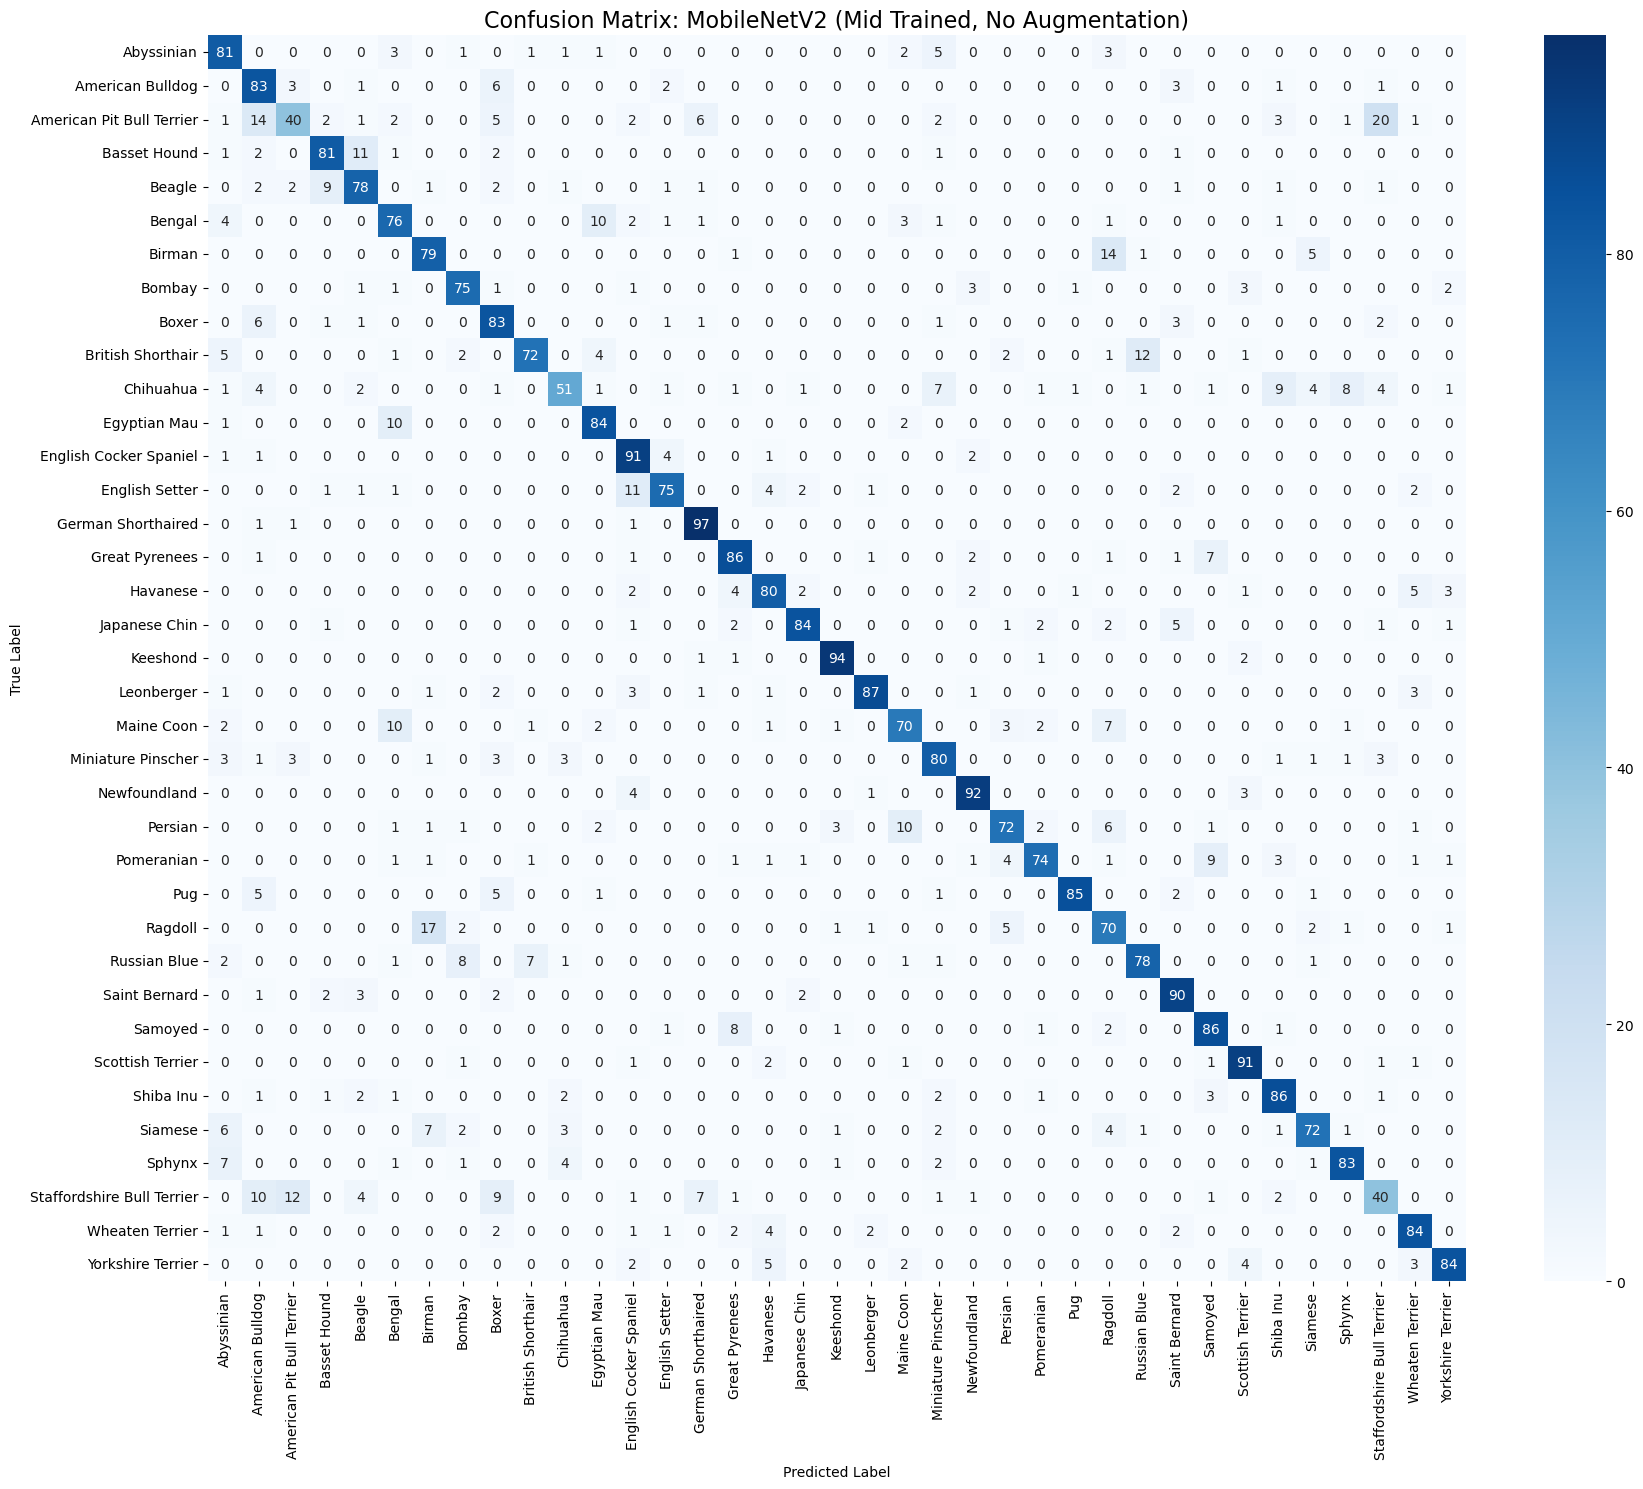


==================== Confusion Matrix: MobileNetV2 (Head Trained, No Augmentation) ====================


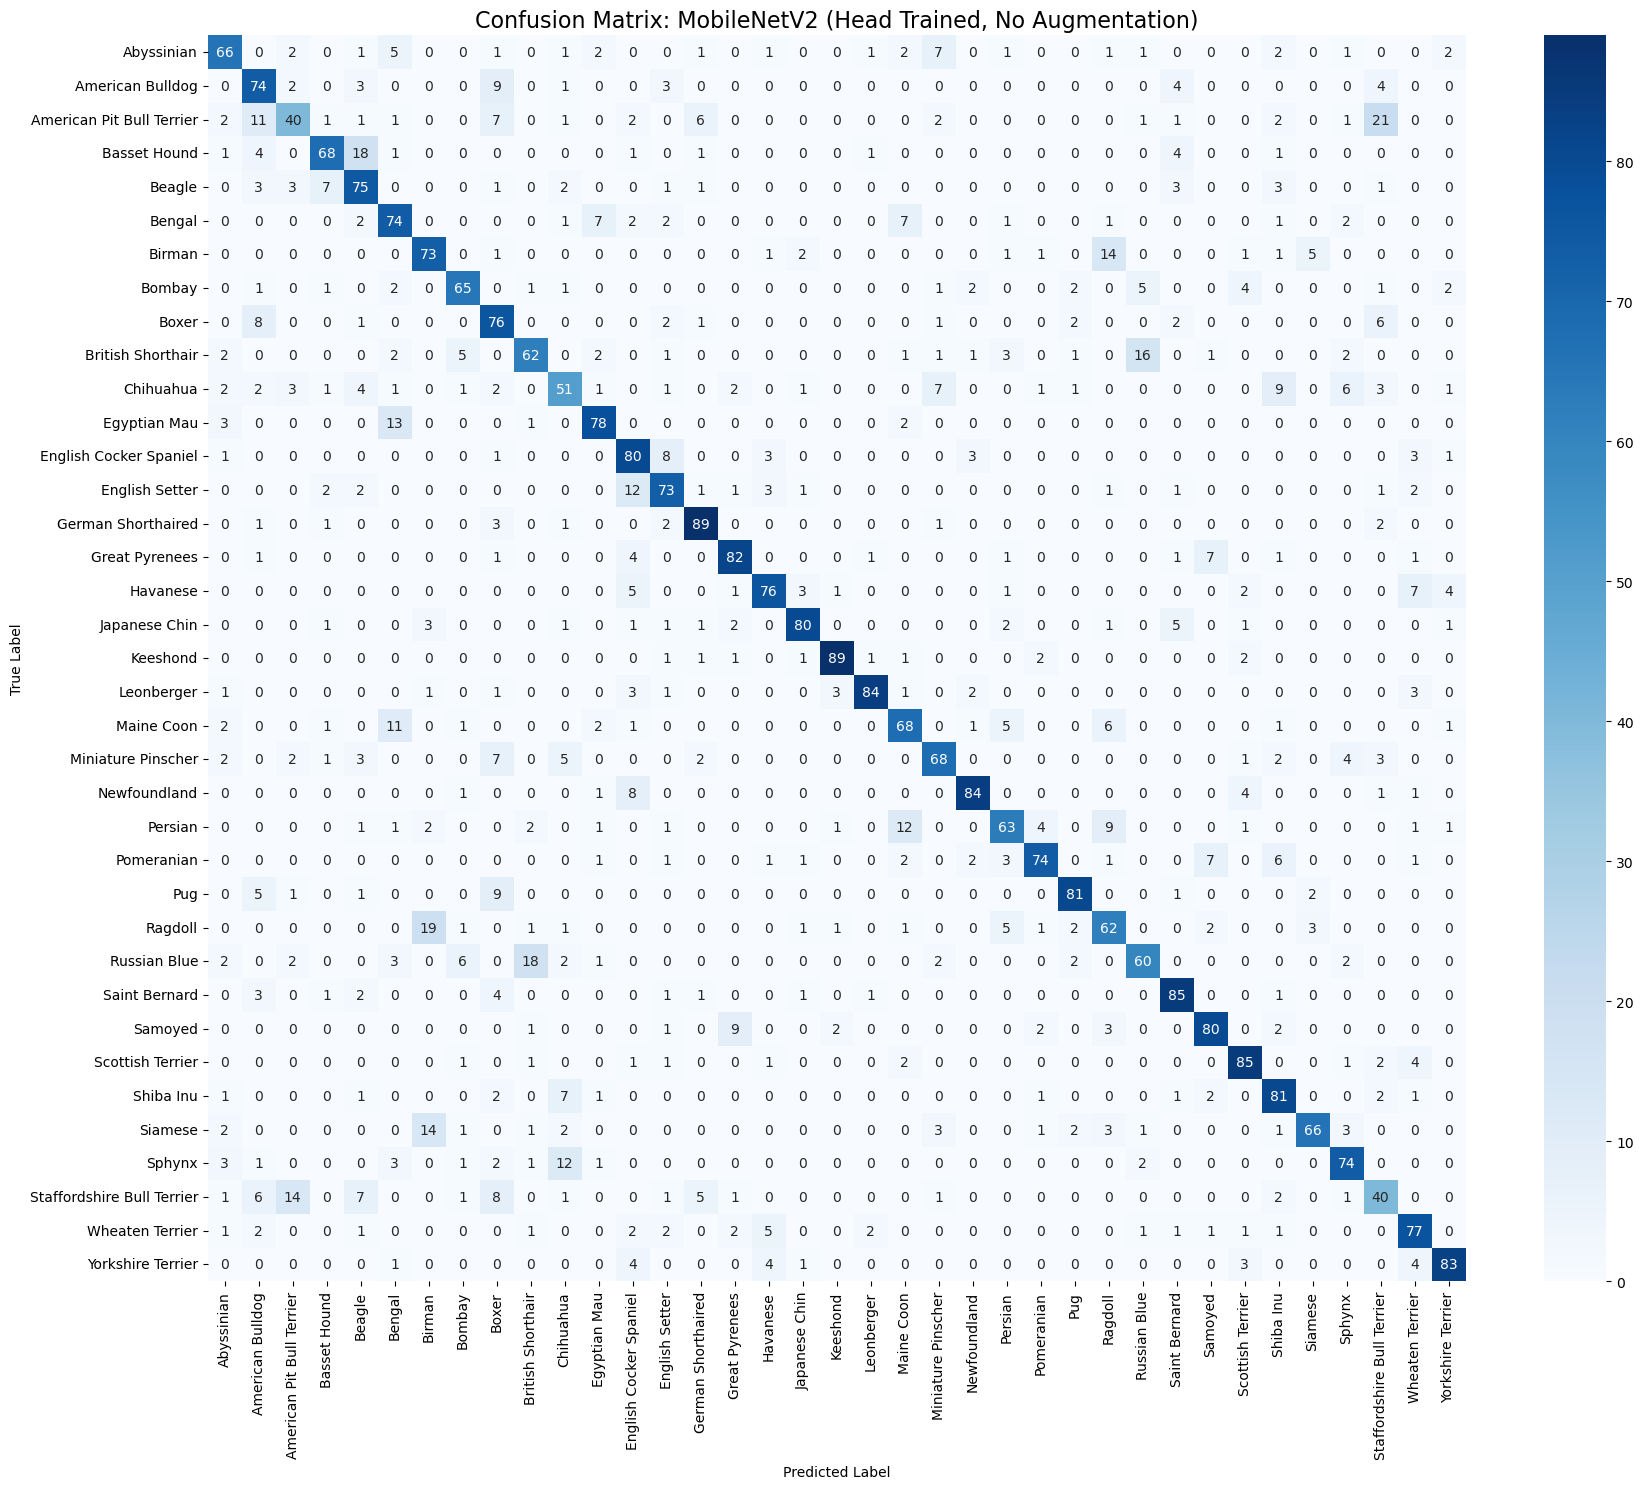


==================== Confusion Matrix: MobileNetV2 (Mid Trained, Augmentation) ====================


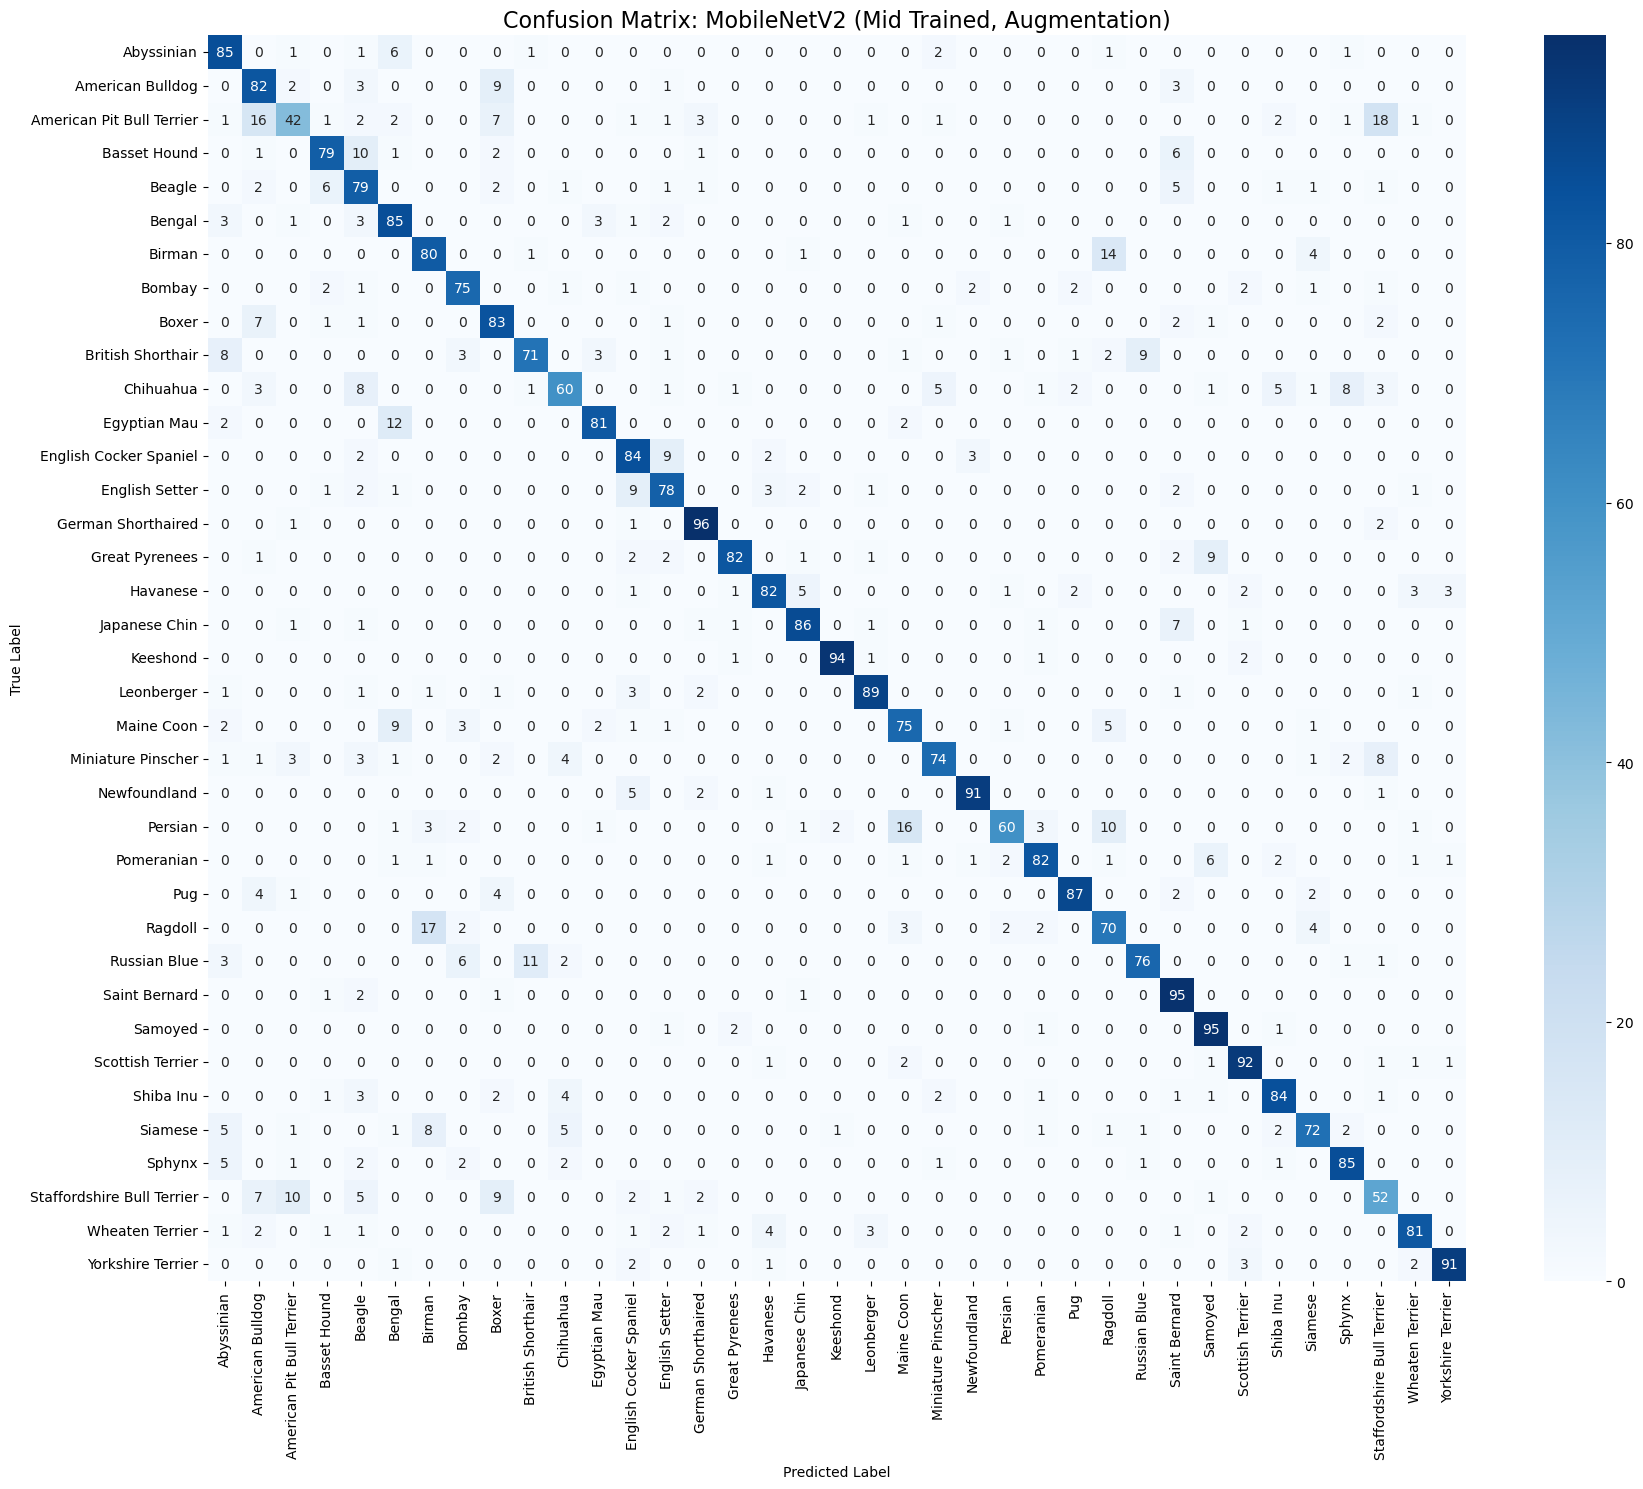


==================== Confusion Matrix: ResNet50 (Mid Trained, No Augmentation) ====================


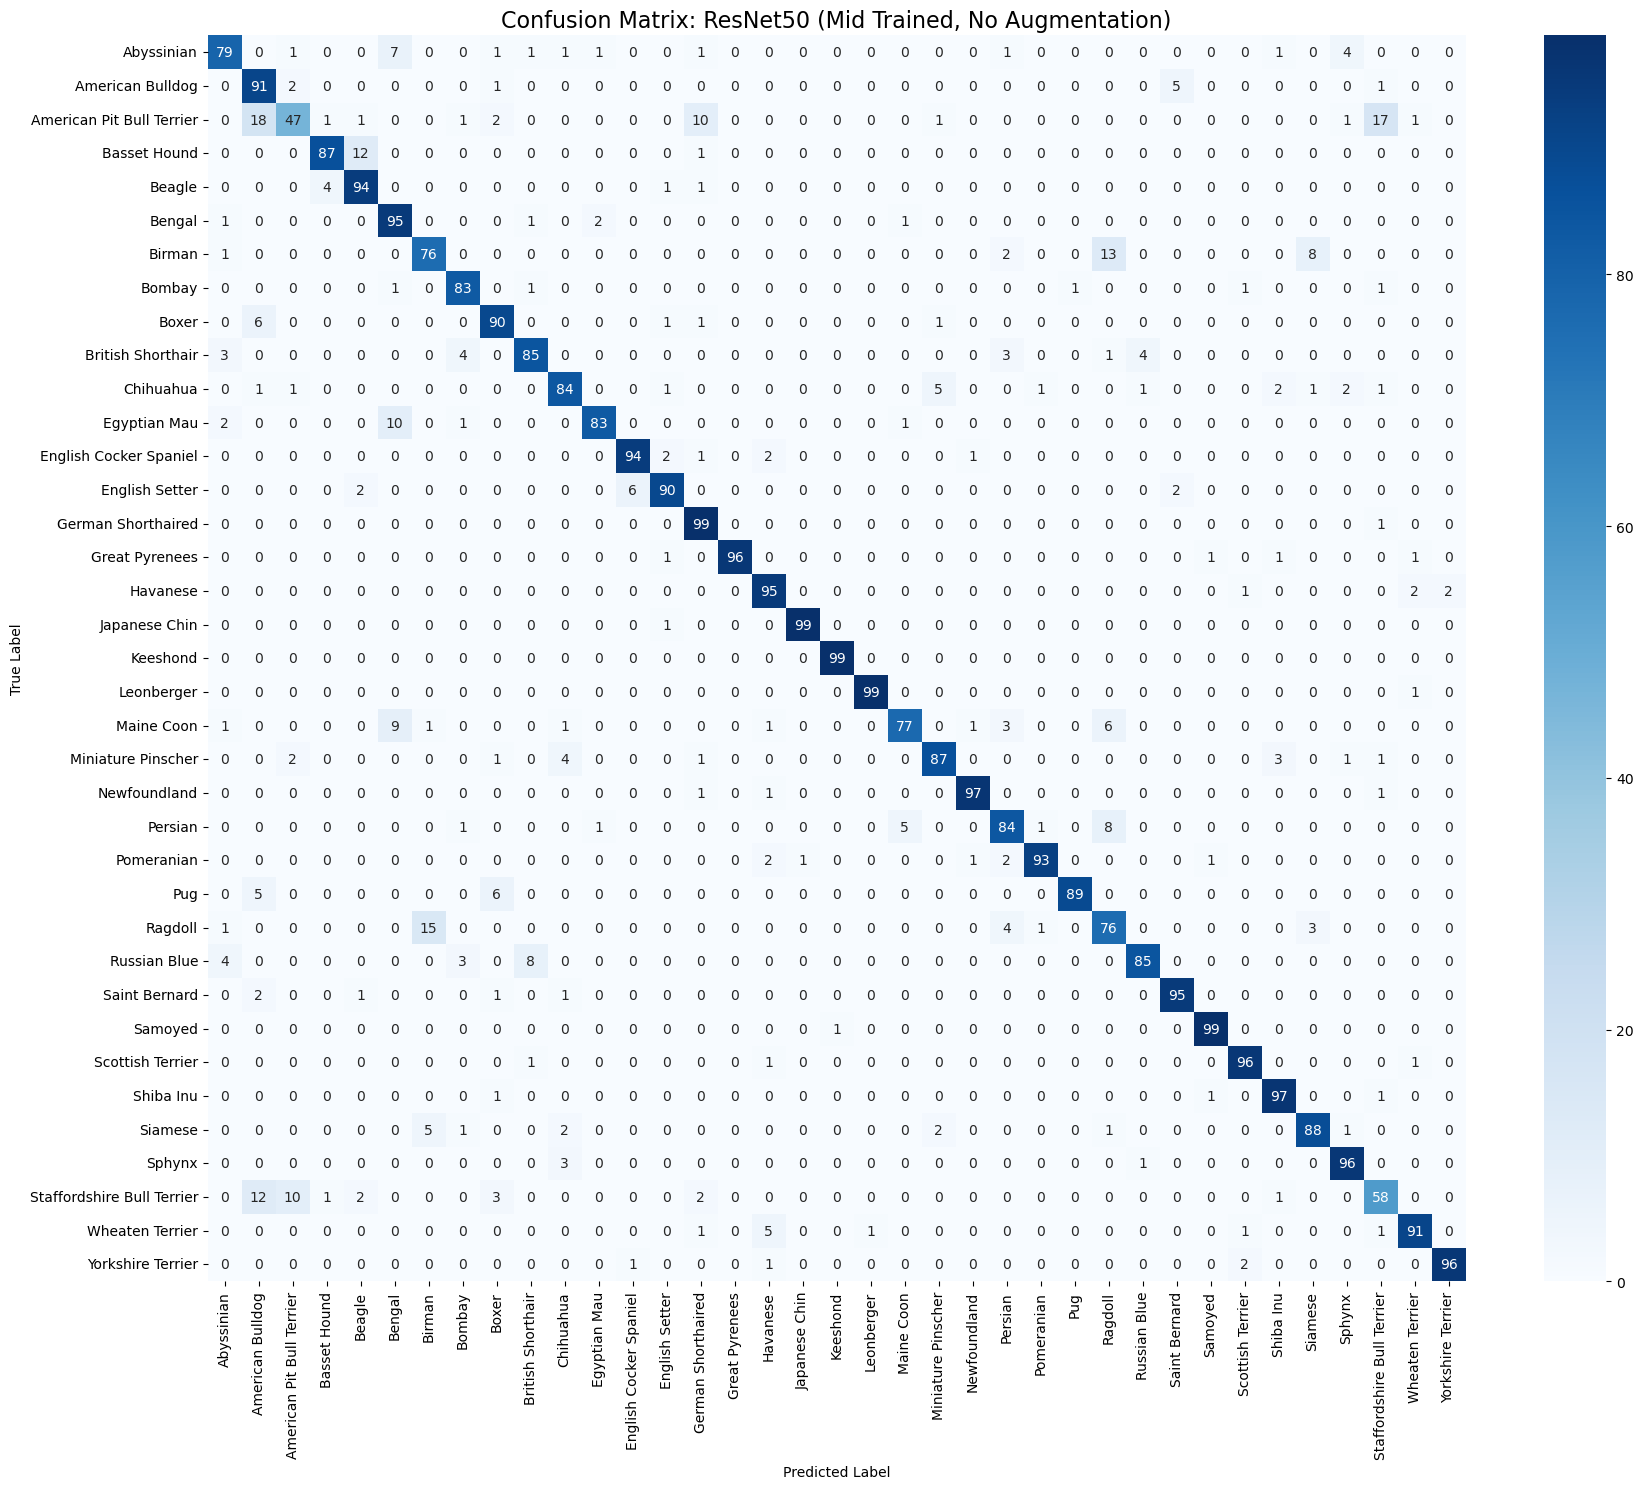


==================== Confusion Matrix: ResNet50 (Head Trained, Augmentation) ====================


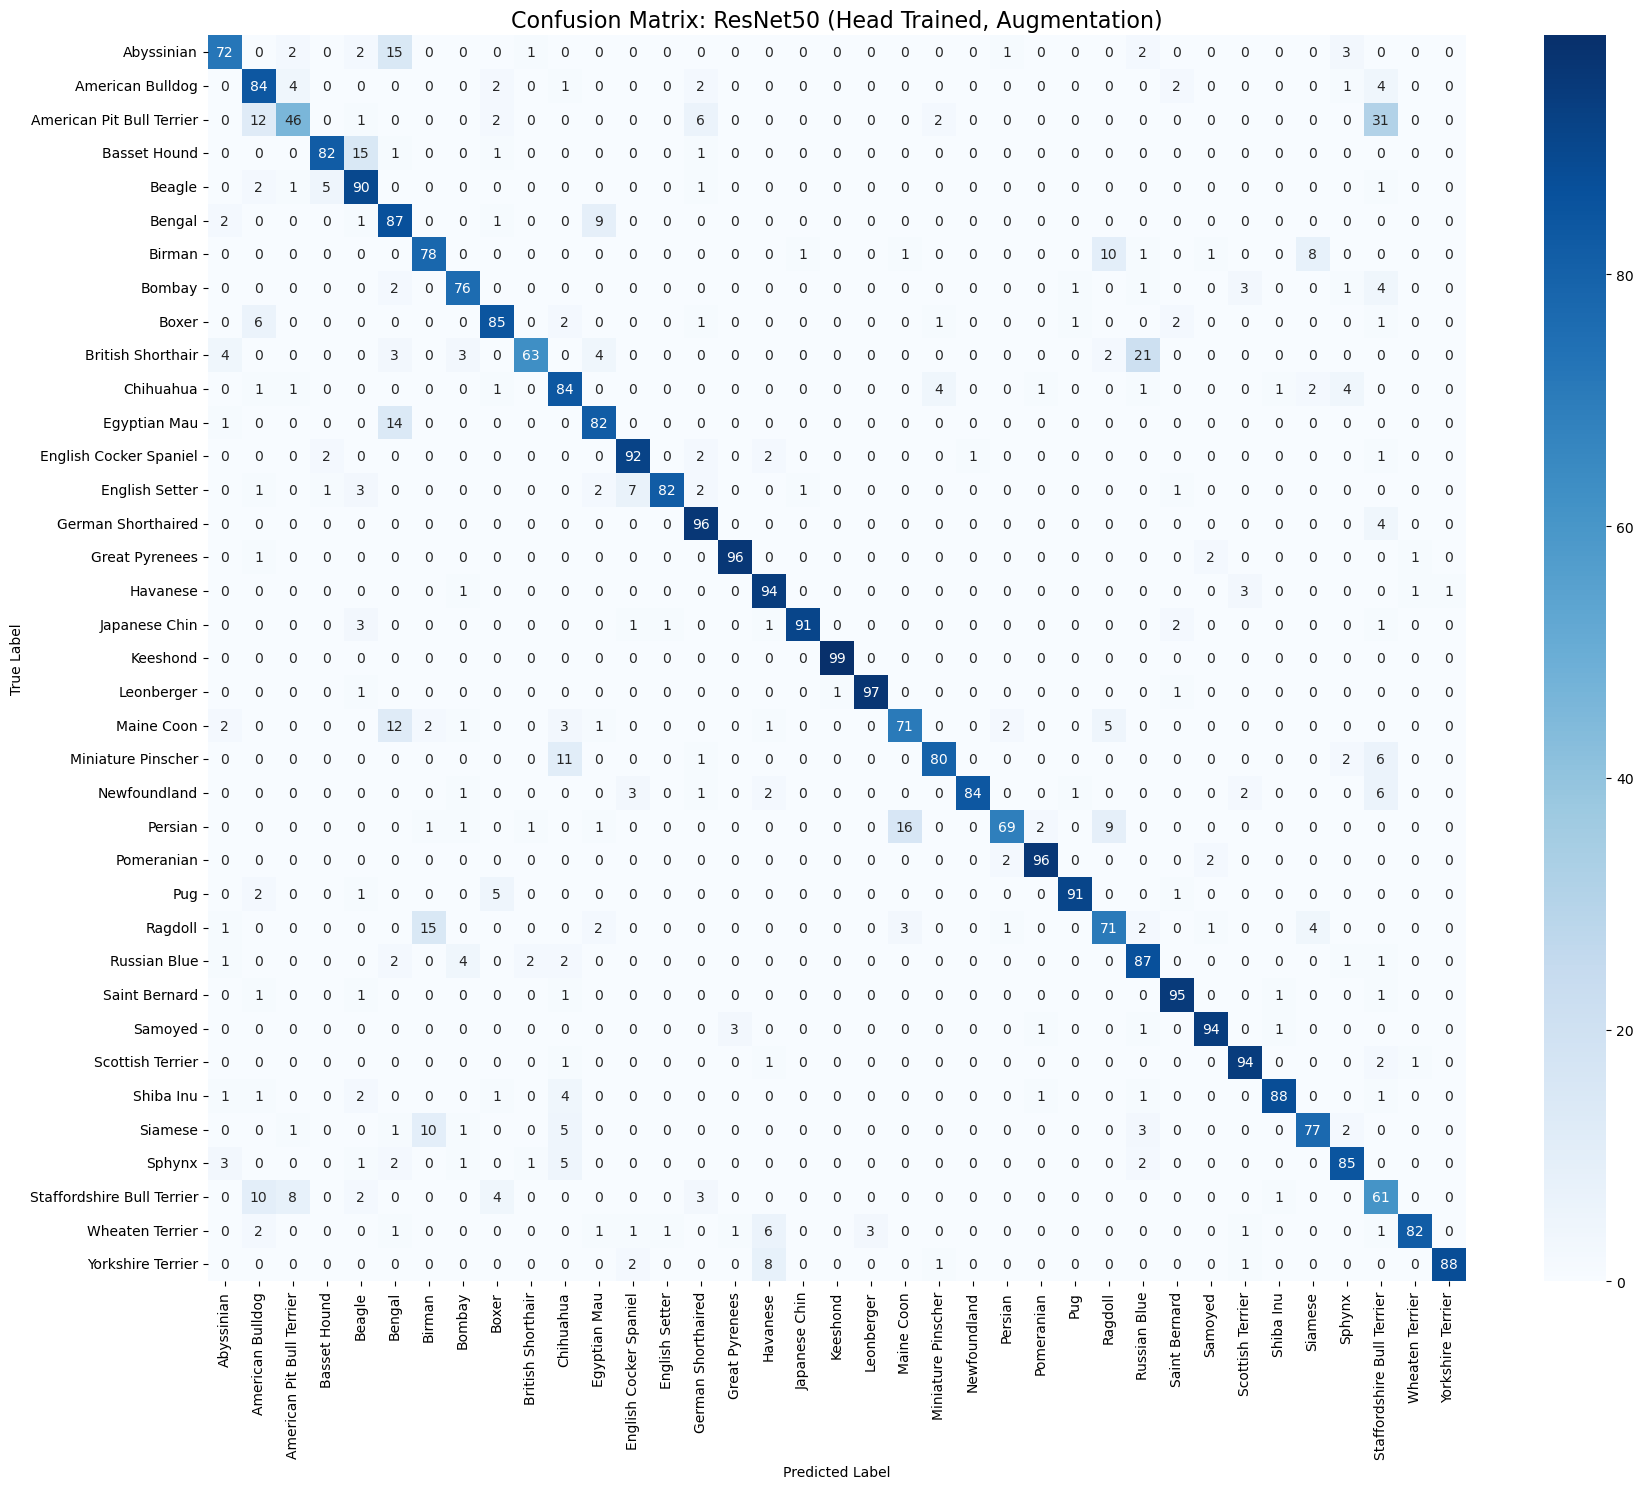


==================== Confusion Matrix: ResNet50 (Head Trained, No Augmentation) ====================


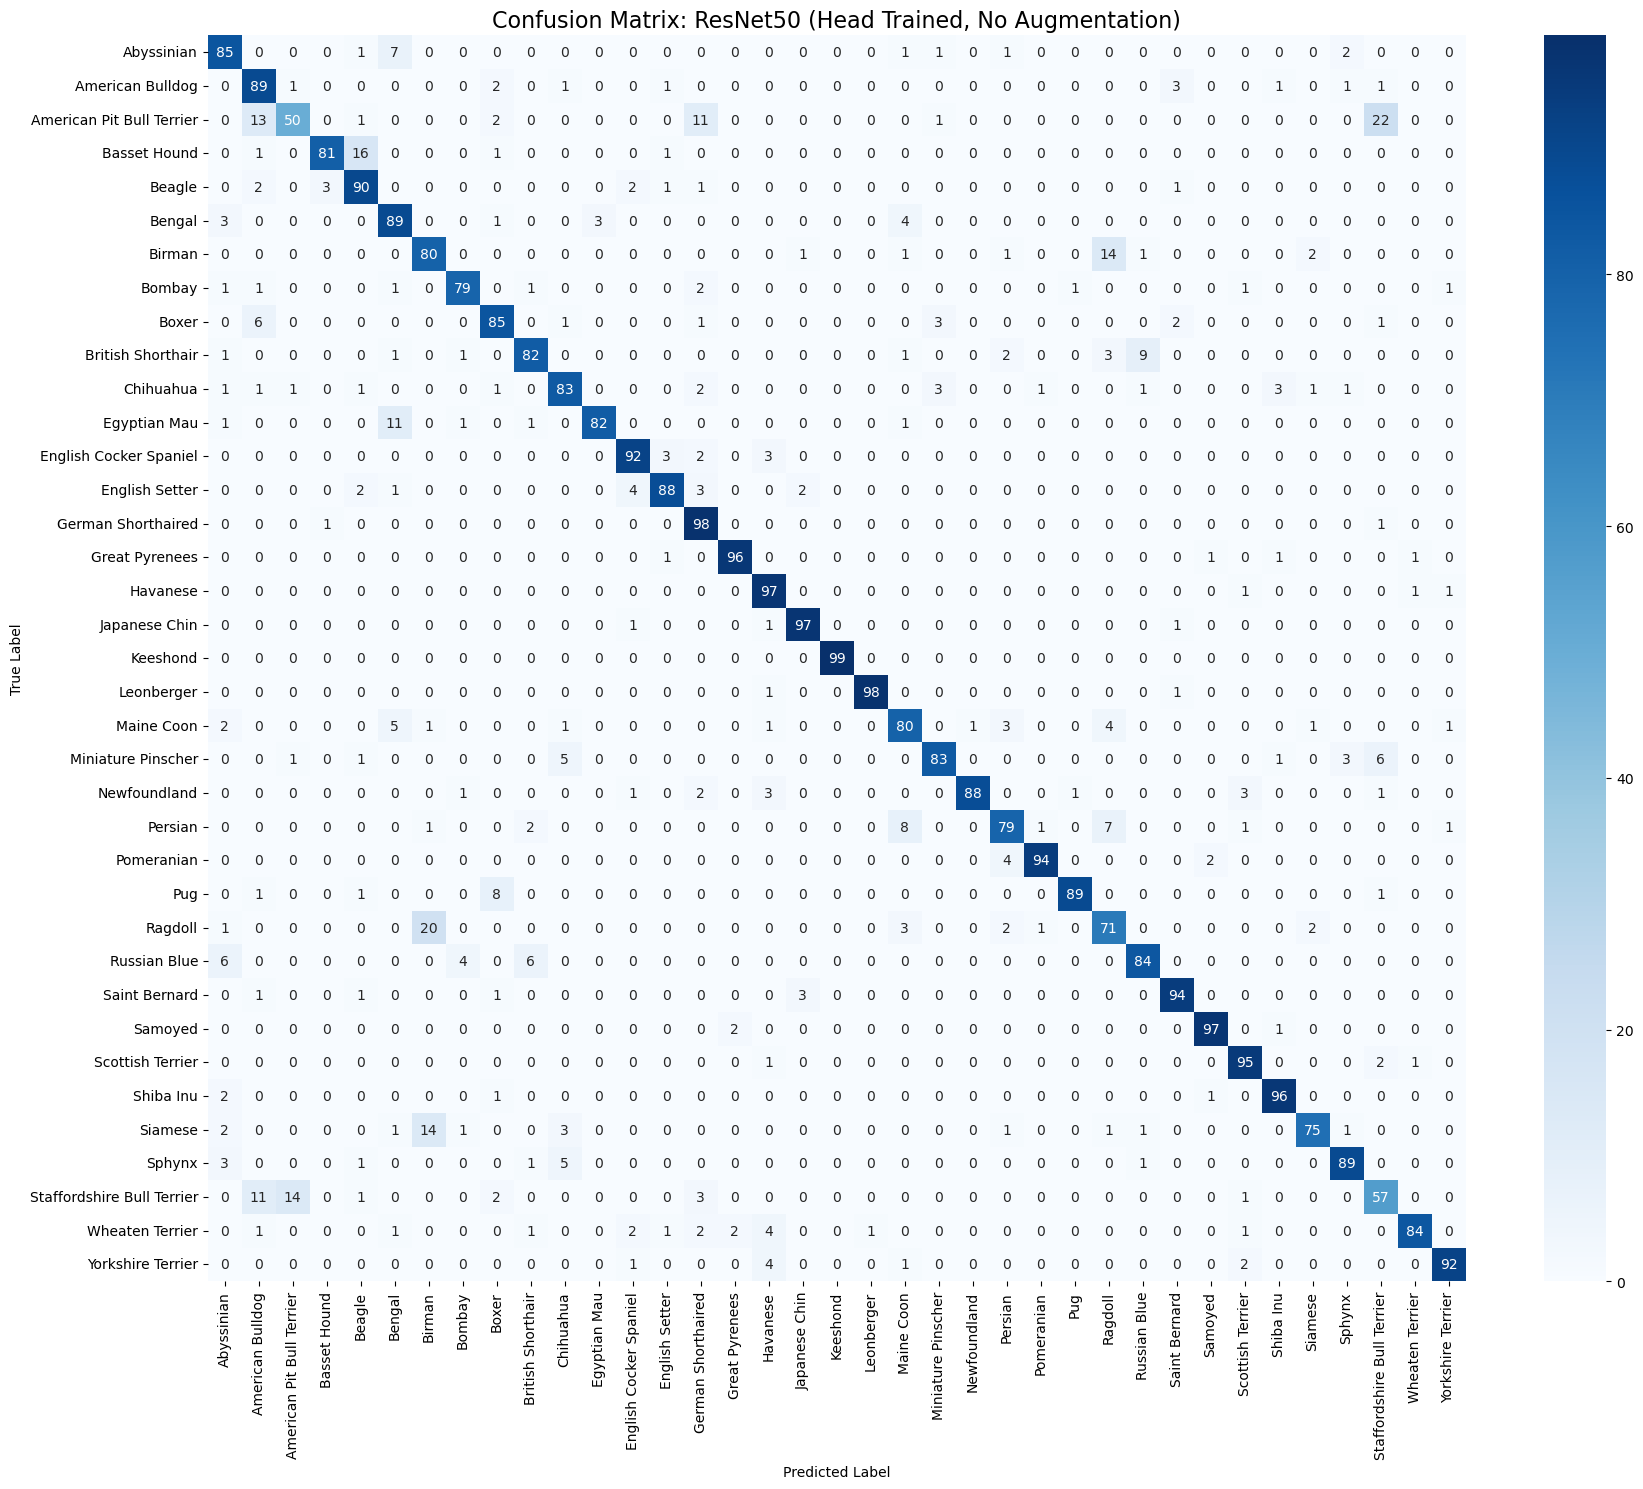


==================== Confusion Matrix: ResNet50 (Mid Trained, Augmentation) ====================


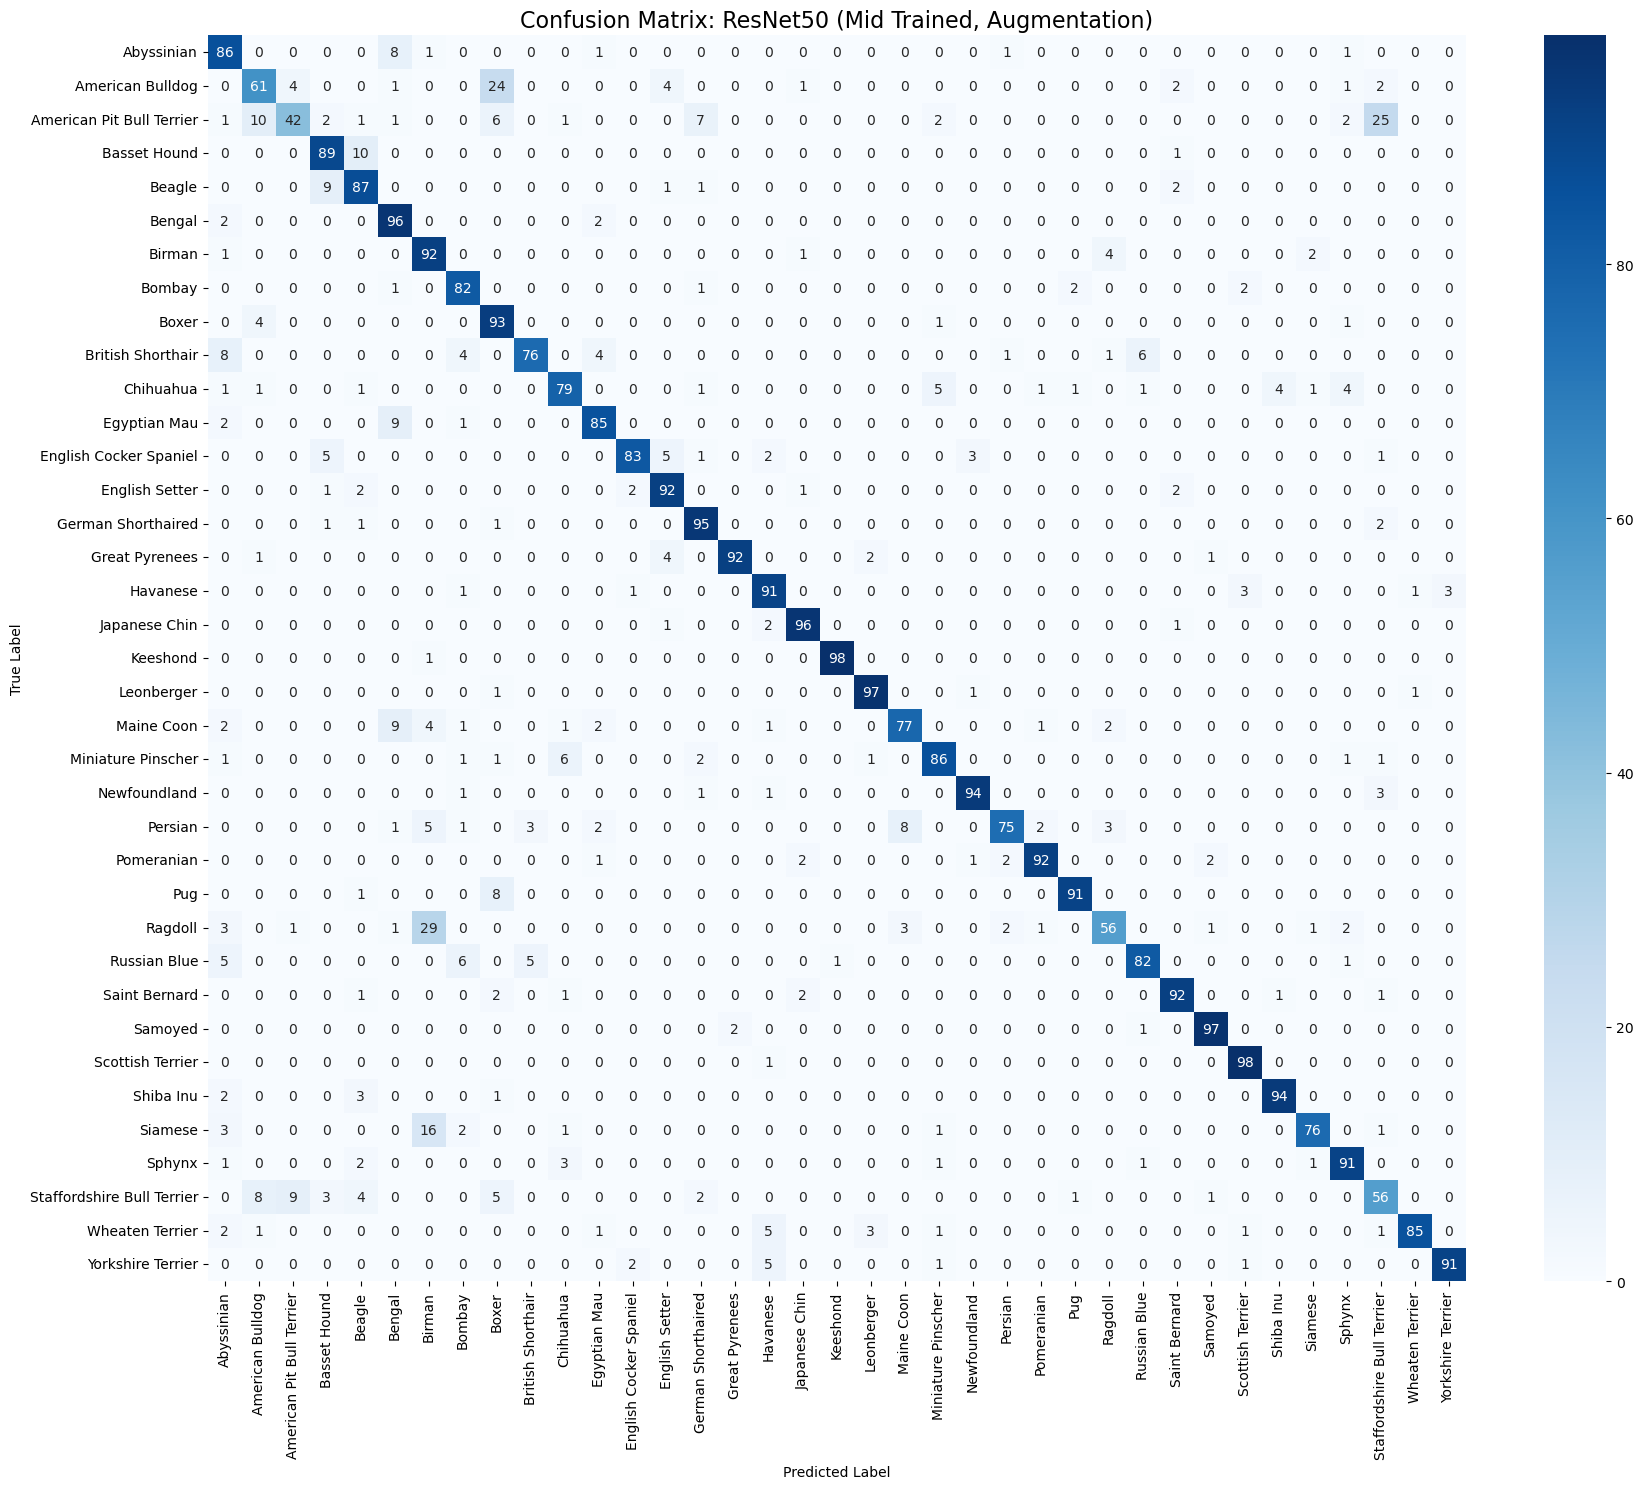

In [31]:
for config in MODEL_CONFIGS:
    print(f"\n{'='*20} Confusion Matrix: {config['name']} {'='*20}")
    metrics_df = load_metrics(config["metrics_file"])
    predictions_df = load_predictions(config["predictions_file"])

    if metrics_df is None or predictions_df is None:
        print(f"Skipping {config['name']} due to missing files.")
        continue

    class_names_ordered = get_class_names(metrics_df)
    if 'true_label_idx' in predictions_df.columns and 'predicted_label_idx' in predictions_df.columns:
        unique_true_labels = sorted(predictions_df['true_label_name'].unique())
        if not all(item in unique_true_labels for item in class_names_ordered) or not all(item in class_names_ordered for item in unique_true_labels):
            cm_display_labels = unique_true_labels
        else:
            cm_display_labels = class_names_ordered

        cm = confusion_matrix(
            predictions_df['true_label_idx'],
            predictions_df['predicted_label_idx'],
            labels=np.arange(len(cm_display_labels))
        )
        plt.figure(figsize=CM_FIG_SIZE)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=cm_display_labels, yticklabels=cm_display_labels)
        plt.title(f"Confusion Matrix: {config['name']}", fontsize=16)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping: 'true_label_idx' or 'predicted_label_idx' not found in predictions.")

### Observations
The confusion matrices reveal several important trends in model performance. Distinct classes such as Keeshond, Scottish Terrier, Samoyed, Leonberger, and Great Pyrenees consistently exhibit strong diagonal values, indicating high precision and recall with minimal confusion. In contrast, there are frequent misclassifications among visually similar breeds, particularly American Pit Bull Terrier, Staffordshire Bull Terrier, and American Bulldog, as shown by prominent off-diagonal values between these classes. These confusion patterns are consistent across all evaluated models, suggesting that certain breed pairs are inherently challenging to distinguish. Additionally, the matrices reflect class imbalance, with some classes having lower support, which can lead to greater variability in their confusion rates and performance metrics. Notably, ResNet50 models tend to produce cleaner confusion matrices with fewer off-diagonal errors, especially when trained with more layers and data augmentation. Overall, the confusion matrices highlight specific class pairs where targeted data augmentation, additional training data, or specialized loss functions could help reduce misclassification and further improve model performance.

## Misclassification
In this section, we analyze the most common misclassifications made by each model. We identify which classes are most frequently predicted incorrectly, visualize the top misclassified classes, and highlight specific class pairs that are often confused—such as the notable confusion between American Pit Bull Terrier and Staffordshire Bull Terrier. This analysis helps pinpoint challenging classes and provides insights into where the models struggle, guiding future improvements in data collection, augmentation, or model architecture.


==================== MobileNetV2 (Head Trained, Augmentation) ====================


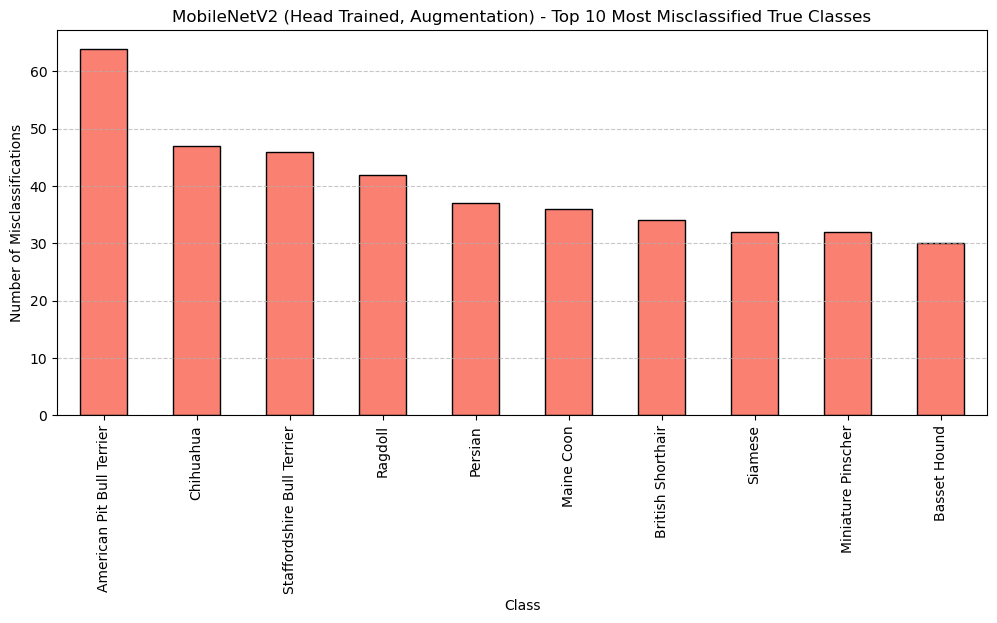


==================== MobileNetV2 (Mid Trained, No Augmentation) ====================


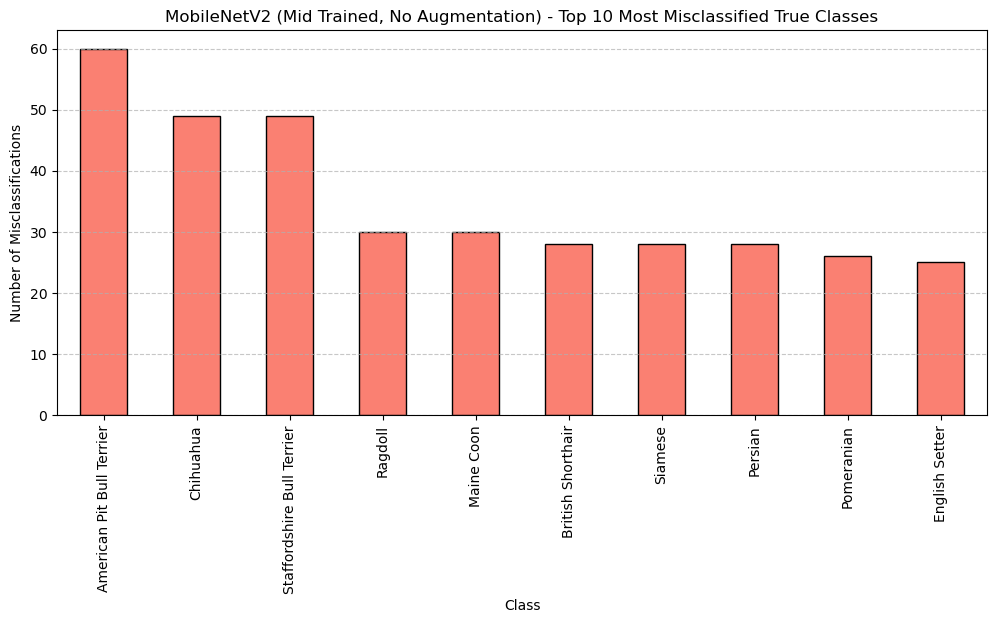


==================== MobileNetV2 (Head Trained, No Augmentation) ====================


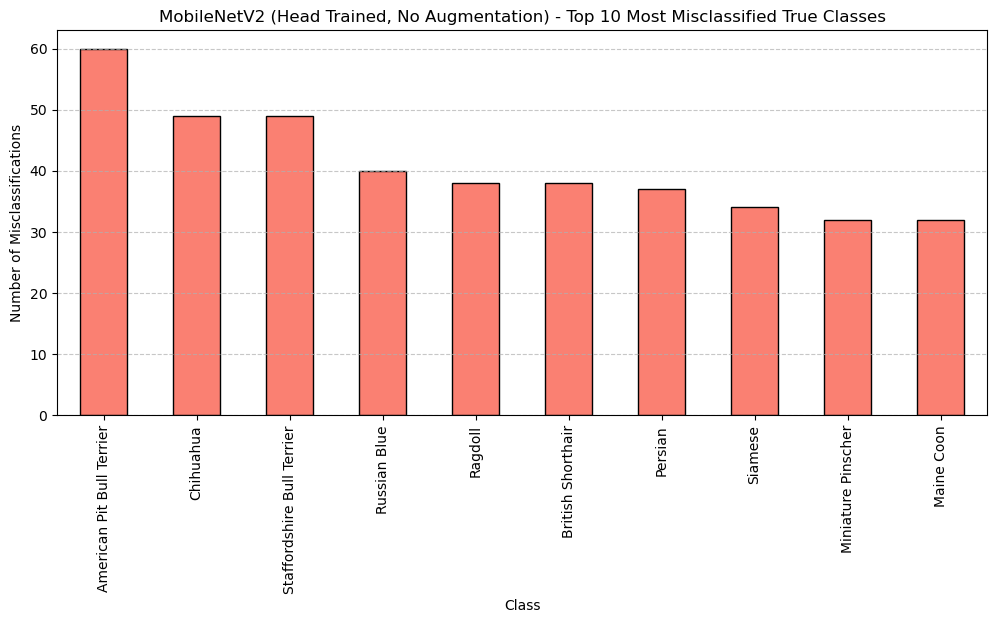


==================== MobileNetV2 (Mid Trained, Augmentation) ====================


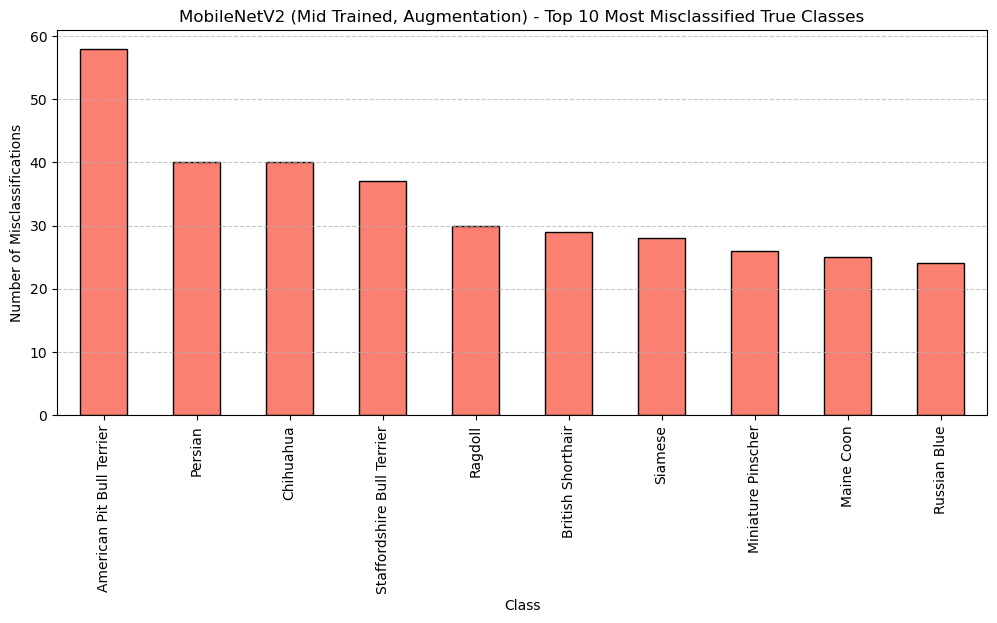


==================== ResNet50 (Mid Trained, No Augmentation) ====================


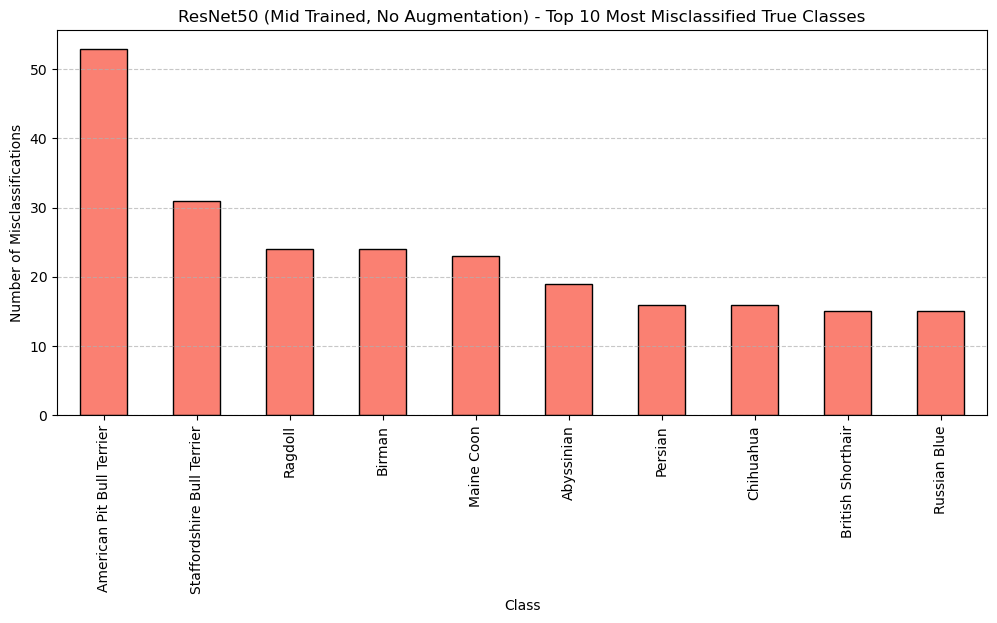


==================== ResNet50 (Head Trained, Augmentation) ====================


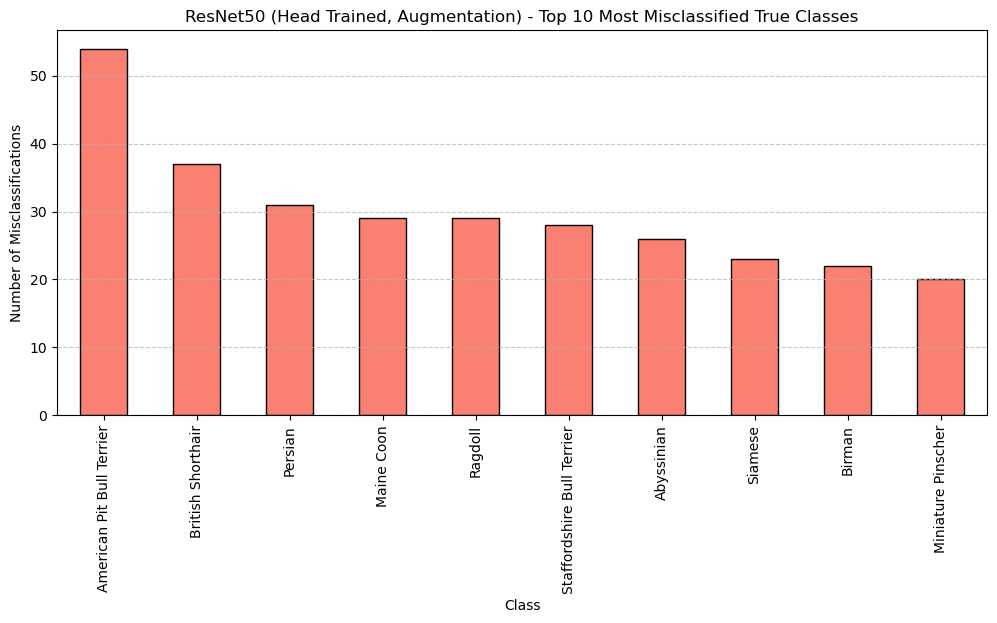


==================== ResNet50 (Head Trained, No Augmentation) ====================


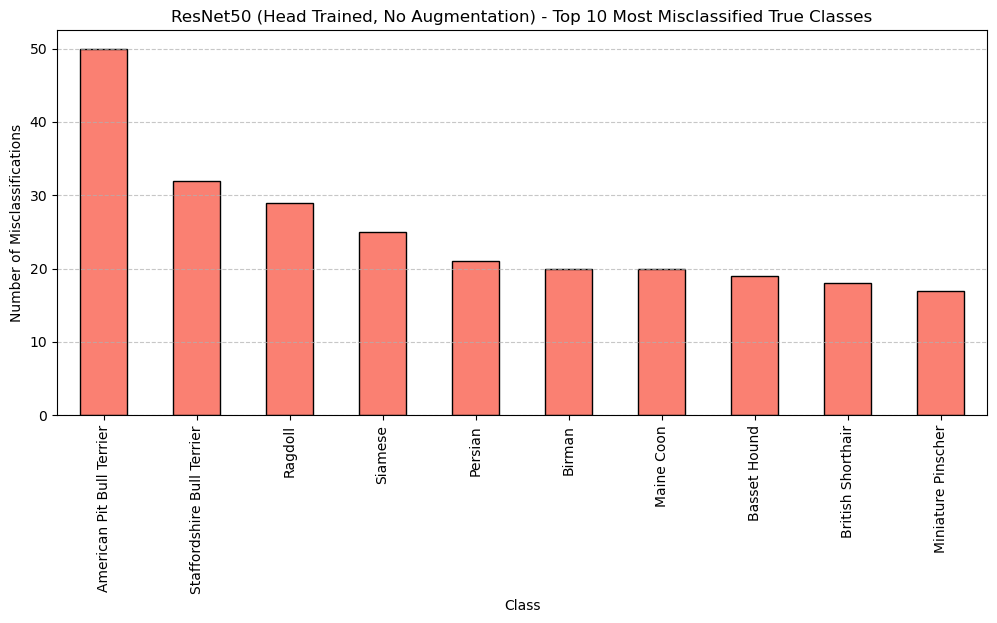


==================== ResNet50 (Mid Trained, Augmentation) ====================


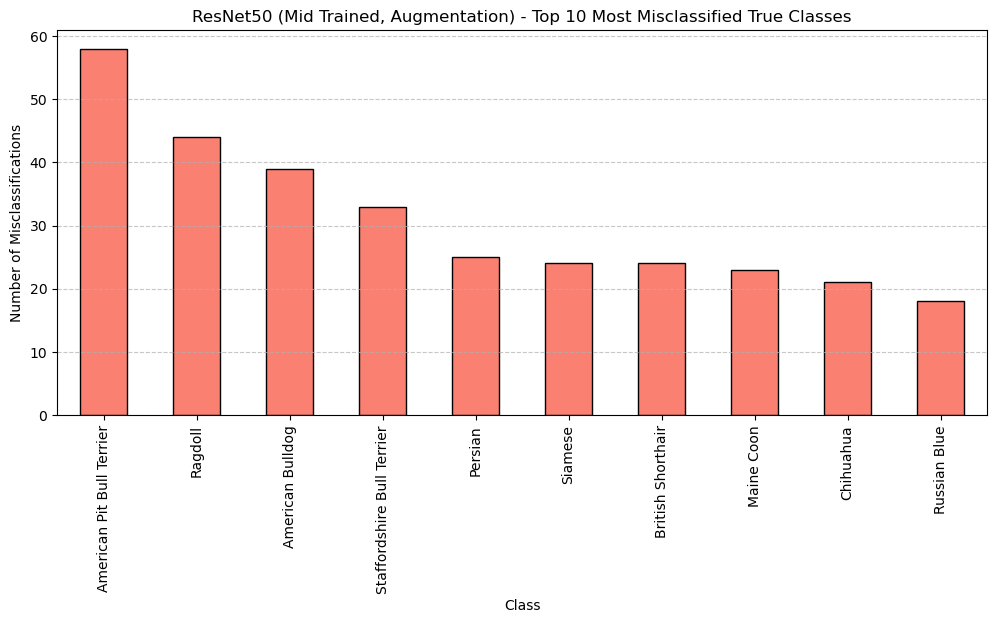

In [34]:
metrics_to_plot = ['f1-score', 'precision', 'recall']

for config in MODEL_CONFIGS:
    print(f"\n{'='*20} {config['name']} {'='*20}")
    metrics_df = load_metrics(config["metrics_file"])
    predictions_df = load_predictions(config["predictions_file"])
    if metrics_df is None or predictions_df is None:
        print("Skipping due to missing files.")
        continue

    # Remove summary rows for per-class analysis
    class_metrics_df = metrics_df.drop(['macro avg', 'weighted avg'], errors='ignore')


    # Misclassification Analysis: Top misclassified classes
    misclassified_counts = predictions_df[predictions_df['true_label_name'] != predictions_df['predicted_label_name']]['true_label_name'].value_counts()
    misclassified_counts.head(10).plot(kind='bar', color='salmon', edgecolor='k', figsize=(12,5))
    plt.title(f'{config["name"]} - Top 10 Most Misclassified True Classes')
    plt.ylabel('Number of Misclassifications')
    plt.xlabel('Class')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Observations
The misclassification analysis highlights several key trends in model performance. The most frequently misclassified classes include American Pit Bull Terrier, Ragdoll, American Bulldog, and Staffordshire Bull Terrier, indicating these breeds are particularly challenging for the models to distinguish. Notably, there is substantial confusion between American Pit Bull Terrier and Staffordshire Bull Terrier, with 25 instances of the former being predicted as the latter and 9 in the reverse direction. This suggests strong visual similarity or overlapping features between these breeds. In contrast, classes such as Keeshond, Scottish Terrier, Samoyed, Leonberger, and Great Pyrenees consistently achieve high F1-scores and low misclassification rates, reflecting their distinctiveness and the models’ ability to recognize them reliably. Overall, while the models perform well on many classes, targeted improvements are needed for visually similar or underrepresented breeds to further reduce misclassification rates.

## Model Comparison
In this section, we compare the overall performance of all evaluated models using summary metrics such as macro and weighted F1-score, precision, and recall. We visualize these metrics with bar plots for each model, making it easy to identify the best-performing architectures and training strategies. This comparison helps highlight the impact of different model choices, data augmentation, and fine-tuning approaches on classification accuracy and balance across classes. The summary table below provides a quick reference for all key metrics.

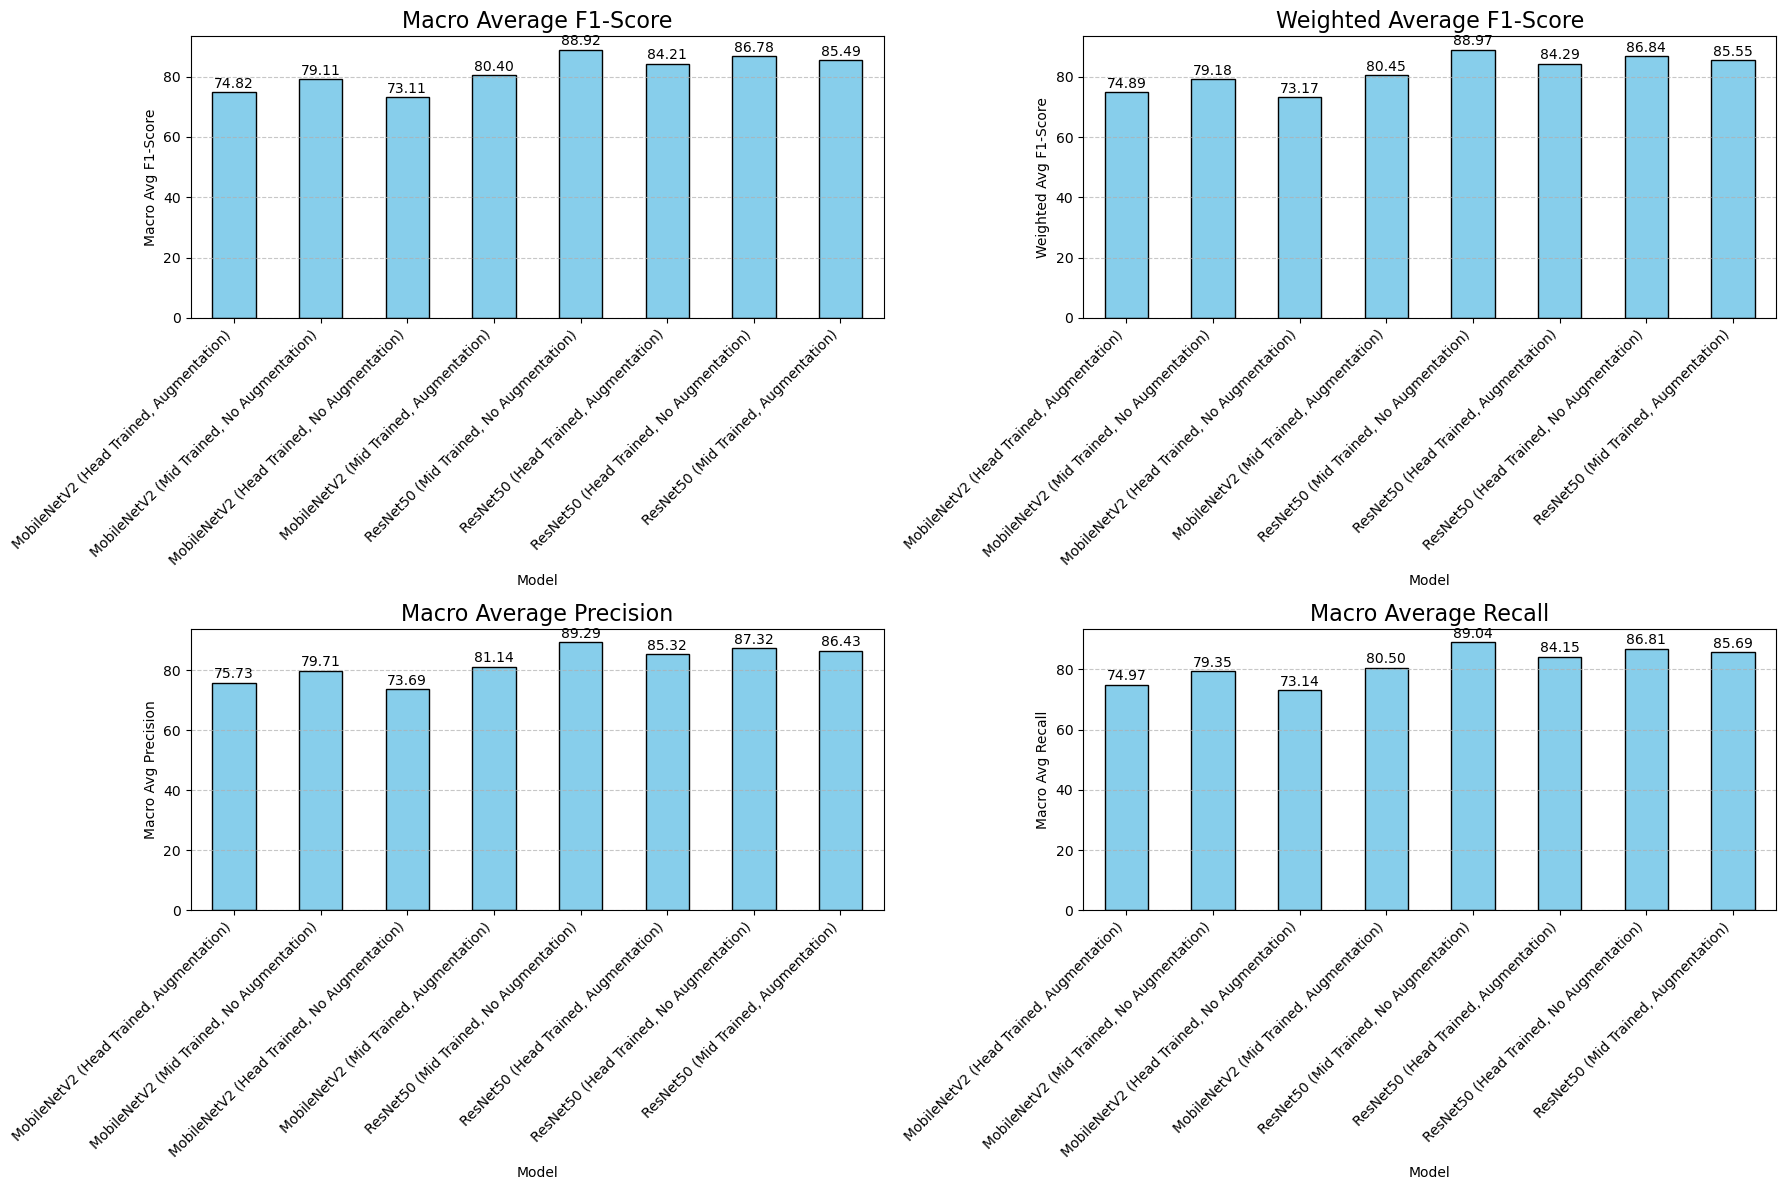

,Macro Avg F1-Score,Weighted Avg F1-Score,Macro Avg Precision,Macro Avg Recall
Model,,,,
"ResNet50 (Mid Trained, No Augmentation)",88.92,88.97,89.29,89.04
"ResNet50 (Head Trained, No Augmentation)",86.78,86.84,87.32,86.81
"ResNet50 (Mid Trained, Augmentation)",85.49,85.55,86.43,85.69
"ResNet50 (Head Trained, Augmentation)",84.21,84.29,85.32,84.15
"MobileNetV2 (Mid Trained, Augmentation)",80.40,80.45,81.14,80.50
"MobileNetV2 (Mid Trained, No Augmentation)",79.11,79.18,79.71,79.35
"MobileNetV2 (Head Trained, Augmentation)",74.82,74.89,75.73,74.97
"MobileNetV2 (Head Trained, No Augmentation)",73.11,73.17,73.69,73.14


In [35]:
# Model Comparison: Bar Plots for Macro/Weighted F1, Precision, Recall

# Prepare summary DataFrame if not already available
if 'summary_df' not in locals():
    summary_df = pd.DataFrame(all_model_summary_metrics)
    summary_df.set_index("Model", inplace=True)

# Plotting
metrics_to_compare = [
    ("Macro Avg F1-Score", "Macro Average F1-Score"),
    ("Weighted Avg F1-Score", "Weighted Average F1-Score"),
    ("Macro Avg Precision", "Macro Average Precision"),
    ("Macro Avg Recall", "Macro Average Recall"),
]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (metric, title) in enumerate(metrics_to_compare):
    summary_df[metric].plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='k')
    axes[i].set_title(title, fontsize=16)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")
    axes[i].set_xticklabels(summary_df.index, rotation=45, ha='right')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    for idx, value in enumerate(summary_df[metric]):
        axes[i].text(idx, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Display the summary table for reference
display(summary_df.round(2).sort_values(by="Macro Avg F1-Score", ascending=False))

### Observations

The confusion matrix and misclassification analysis reveal several key insights:

- **Consistently Well-Recognized Classes:** Breeds such as Keeshond, Scottish Terrier, Samoyed, Leonberger, and Great Pyrenees achieve the highest F1-scores (above 94%), indicating that the models can reliably distinguish these classes with minimal confusion.
- **Challenging Classes:** American Pit Bull Terrier, Staffordshire Bull Terrier, and American Bulldog have the lowest F1-scores (ranging from ~54% to ~66%) and are frequently misclassified, often with each other. This suggests strong visual similarity and highlights a persistent challenge for all models.
- **Specific Confusion Patterns:** There is a notable asymmetry in misclassification between American Pit Bull Terrier and Staffordshire Bull Terrier (e.g., 25 vs. 9 instances), emphasizing the need for targeted improvements for these breeds.
- **Model Architecture Impact:** ResNet50 models, especially those with mid-layer training and no augmentation, outperform MobileNetV2 models in both macro and weighted F1-scores, demonstrating the benefit of deeper architectures and more extensive fine-tuning.
- **Effect of Data Augmentation:** Models trained with data augmentation generally perform better, particularly when more layers are fine-tuned, supporting the value of augmentation for generalization.
- **Class Imbalance Effects:** Classes with fewer samples or lower support tend to have more variable performance and higher misclassification rates.

Overall, while the models perform well on many classes, visually similar and underrepresented breeds remain challenging. Addressing these issues with additional data, advanced augmentation, or specialized loss functions could further improve classification accuracy.

## Conclusion
Overall, this analysis demonstrates that while modern deep learning models can achieve high accuracy on many classes, certain visually similar or underrepresented breeds remain challenging. Continued improvements in data quality, augmentation, and model architecture are essential for further reducing misclassification and achieving robust, balanced performance across all classes.

### Confusion Matrices

The confusion matrices for each model provide a detailed view of prediction accuracy across all classes. Strong diagonal values indicate high precision and recall for distinct breeds such as **Keeshond**, **Scottish Terrier**, **Samoyed**, **Leonberger**, and **Great Pyrenees**. Off-diagonal values highlight frequent confusions, especially between visually similar breeds like **American Pit Bull Terrier** and **Staffordshire Bull Terrier**. These matrices reveal both the strengths of the models and persistent challenges, guiding targeted improvements in data augmentation and model design. Visualizations of the confusion matrices are included in the analysis above for reference.

### Model Misclassification

- **Most Frequently Misclassified Classes:**  
        The classes with the highest number of misclassifications are **American Pit Bull Terrier** (58), **Ragdoll** (44), **American Bulldog** (39), and **Staffordshire Bull Terrier** (33). These classes are often confused with visually similar breeds or those with overlapping features.

- **Common Misclassification Patterns:**  
        - **American Pit Bull Terrier** is most often misclassified as **Staffordshire Bull Terrier** (25 times).
        - **Staffordshire Bull Terrier** is misclassified as **American Pit Bull Terrier** (9 times).
        - **Ragdoll** is frequently confused with **Siamese** and **Japanese Chin**.
        - **American Bulldog** is sometimes misclassified as **Boxer** or **Beagle**.

- **Implications:**  
        These patterns highlight the challenge of distinguishing between certain breeds, especially those with similar appearances. Addressing these misclassifications may require additional data, more discriminative features, or targeted augmentation strategies.

### Model Comparison

| Model Name                                 | Macro Avg F1 | Weighted Avg F1 | Macro Precision | Macro Recall |
|--------------------------------------------|:------------:|:---------------:|:---------------:|:------------:|
| MobileNetV2 (Head Trained, Augmentation)   |    74.82     |      74.89      |      75.73      |    74.97     |
| MobileNetV2 (Mid Trained, No Augmentation) |    79.11     |      79.18      |      79.71      |    79.35     |
| MobileNetV2 (Head Trained, No Augmentation)|    73.11     |      73.17      |      73.69      |    73.14     |
| MobileNetV2 (Mid Trained, Augmentation)    |    80.40     |      80.45      |      81.14      |    80.50     |
| ResNet50 (Mid Trained, No Augmentation)    |    88.92     |      88.97      |      89.29      |    89.04     |
| ResNet50 (Head Trained, Augmentation)      |    84.21     |      84.29      |      85.32      |    84.15     |
| ResNet50 (Head Trained, No Augmentation)   |    86.78     |      86.84      |      87.32      |    86.81     |
| ResNet50 (Mid Trained, Augmentation)       |    85.49     |      85.55      |      86.43      |    85.69     |

- **Best Overall Performance:**  
    **ResNet50 (Mid Trained, No Augmentation)** achieves the highest macro and weighted F1-scores, indicating superior generalization and class balance.

- **Effect of Augmentation:**  
    For both MobileNetV2 and ResNet50, models trained with augmentation generally outperform their non-augmented counterparts, especially when more layers are trained ("Mid Trained" vs. "Head Trained").

- **Architecture Impact:**  
    ResNet50 models consistently outperform MobileNetV2 models, suggesting that deeper architectures with more capacity are better suited for this multi-class classification task.

### Summary
ResNet50 models, particularly those with mid-layer training and no augmentation, deliver the best overall results, achieving the highest macro and weighted F1-scores among all evaluated architectures. Both data augmentation and deeper fine-tuning (mid-layer training) contribute positively to model performance, with augmented models generally outperforming their non-augmented counterparts. However, class confusion remains a persistent challenge for visually similar breeds, such as American Pit Bull Terrier and Staffordshire Bull Terrier, indicating a need for more discriminative features, targeted data augmentation, or additional data for these classes

Further improvements could focus on addressing specific confusions and exploring advanced augmentation or loss functions tailored to hard-to-distinguish classes.